# CNN attitude to image classification problem
Maciej Michałek | 25.02.2022

In [1]:
import os
import urllib
import shutil
import azureml
import pathlib

from azureml.core import Experiment
from azureml.core import Workspace, Run
from azureml.core import Environment

from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.8.0


## Experiment setup in Azure ML
Using MLFlow

In [2]:
import mlflow
from azureml.core import Workspace

ws = Workspace.from_config() # if working remotely we need to add workspace configuraton file to repo

mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

# experiment name
experiment_name = 'images_classification'
mlflow.set_experiment(experiment_name)

Performing interactive authentication. Please follow the instructions on the terminal.


To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code C8FKP7EXV to authenticate.


Interactive authentication successfully completed.


2022/03/03 08:43:19 INFO mlflow.tracking.fluent: Experiment with name 'images_classification' does not exist. Creating a new experiment.


<Experiment: artifact_location='', experiment_id='534a6ffd-8dae-4334-99e5-ac11de43374f', lifecycle_stage='active', name='images_classification', tags={}>

## Data aquisition

In [1]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

--2022-03-02 10:52:28--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.208.112, 216.58.214.16, 142.250.179.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.208.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  43.2MB/s    in 5.1s    

2022-03-02 10:52:36 (43.2 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [2]:
# todo: why zip is so slow???
!tar -xvf flower_photos.tgz

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_photos/roses/3292434691_392071d702_n.jpg
flower_photos/roses/5273722065_c85d8543c2_m.jpg
flower_photos/roses/2215318403_06eb99176a.jpg
flower_photos/roses/172311368_49412f881b.jpg
flower_photos/roses/15255964454_0a64eb67fa.jpg
flower_pho

In [3]:
# faster data load method
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(None, origin=dataset_url, extract=True, archive_format=['tar', 'gzip'])
data_dir = pathlib.Path(data_dir)
print(data_dir.glob)

228827136/228813984 [==============================] - 5s 0us/step
<bound method Path.glob of PosixPath('/home/azureuser/.keras/datasets/flower_photos.tgz')>


In [4]:
# Data path and images count
data_dir = '/home/azureuser/.keras/datasets/flower_photos'
data_dir = pathlib.Path(data_dir)
print(data_dir, type(data_dir))
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Image count: {image_count:n}')

/home/azureuser/.keras/datasets/flower_photos <class 'pathlib.PosixPath'>
Image count: 3670


### Multithread pictures verification

In [5]:
from multiprocessing import Pool

data_inputs = list(data_dir.glob('*/*.jpg'))
print(f'Data to verify: {len(data_inputs):n}')

def verify_image(img_path):
    try:
        img = tf.io.read_file(str(img_path))
        tf.io.decode_jpeg(img)
        return 0
    except Exception as e:
        # print(str(img_path), '\n')
        os.remove(img_path)
        return 1

pool = Pool(os.cpu_count())
try:
    data_outputs = pool.map(verify_image, data_inputs)
finally: # To make sure processes are closed in the end, even if errors happen
    pool.close()
    pool.join()

print(f'Invalid pictures: {sum(data_outputs):n}')

data_inputs = list(data_dir.glob('*/*.jpg'))
print(f'Data left after verification: {len(data_inputs):n}')

Data to verify: 3670
Invalid pictures: 0
Data left after verification: 3670


In [6]:
# register DataSet in Azure
from azureml.core import Dataset, Datastore
datastore = ws.get_default_datastore()
dataset = Dataset.File.upload_directory(str(data_dir), datastore)

Validating arguments.
Arguments validated.
Uploading file to /
Uploading an estimated of 3671 files
Uploading /home/azureuser/.keras/datasets/flower_photos/LICENSE.txt
Uploaded /home/azureuser/.keras/datasets/flower_photos/LICENSE.txt, 1 files out of an estimated total of 3671
Uploading /home/azureuser/.keras/datasets/flower_photos/sunflowers/16616096711_12375a0260_n.jpg
Uploaded /home/azureuser/.keras/datasets/flower_photos/sunflowers/16616096711_12375a0260_n.jpg, 2 files out of an estimated total of 3671
Uploading /home/azureuser/.keras/datasets/flower_photos/sunflowers/9825716455_f12bcc8d4e_n.jpg
Uploaded /home/azureuser/.keras/datasets/flower_photos/sunflowers/9825716455_f12bcc8d4e_n.jpg, 3 files out of an estimated total of 3671
Uploading /home/azureuser/.keras/datasets/flower_photos/sunflowers/7530313068_ddd2dc1f44_m.jpg
Uploaded /home/azureuser/.keras/datasets/flower_photos/sunflowers/7530313068_ddd2dc1f44_m.jpg, 4 files out of an estimated total of 3671
Uploading /home/azureuse

### Images sample view

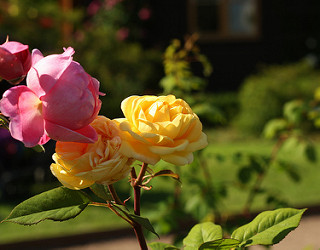

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

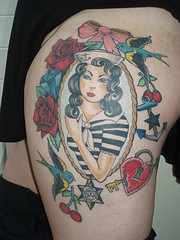

In [8]:
PIL.Image.open(str(roses[1]))

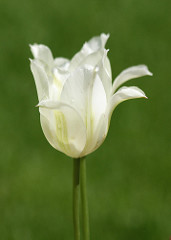

In [9]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

### Images input parameters

In [10]:
# resnet is 224x224x3
# efficientnet B4 is 380x380x3 (https://discuss.pytorch.org/t/input-size-for-efficientnet-versions-from-torchvision-models/140525)
batch_size = 32
img_height = 224
img_width = 224

### DataSets from Azure Datasets

In [12]:
run = Run.get_context()
dataset = run.input_datasets['flowers']

AttributeError: '_OfflineRun' object has no attribute 'input_datasets'

## Train/Test/Val datasets preparation

In [36]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  labels="inferred",
  label_mode="int",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1440 files belonging to 2 classes.
Using 1152 files for training.


In [37]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  labels="inferred",
  label_mode="int",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1440 files belonging to 2 classes.
Using 288 files for validation.


In [38]:
class_names = train_ds.class_names
print('Classes inside dataset:', class_names)

Classes inside dataset: ['roses', 'tulips']


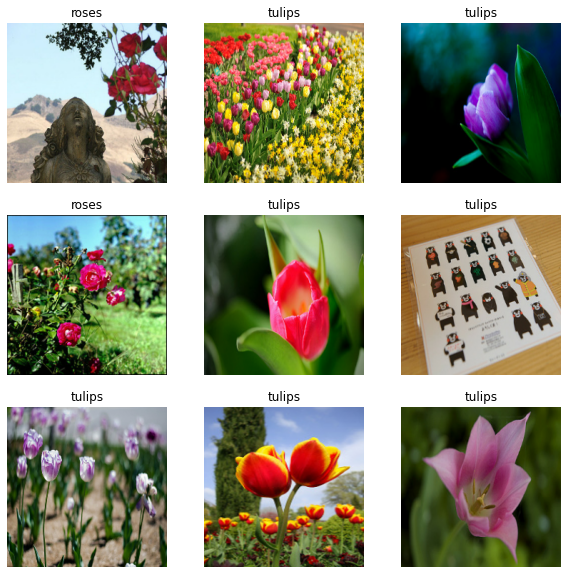

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Dataset performance tuning
https://www.tensorflow.org/guide/data_performance

In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Images normalization
RGB values ranging from 0 to 255 need to be changed into floats from 0 to 1. 

In [41]:
# way to normalize images without adding network layer
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### MLFlow autologger

In [42]:
mlflow.tensorflow.autolog()

2022/03/02 11:31:59 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


## Simple CNN architecture

In [43]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  # layers.Dense(num_classes), # multiclass
  layers.Dense(1,activation='sigmoid') # binary
])

# tf.keras.losses.BinaryCrossentropy for binary classification
# tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) for multiclass

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [44]:
epochs=10
print(f'Batch size: {batch_size}')

with mlflow.start_run(run_name='simple CNN'): # experiment tracking name
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    # steps_per_epoch=steps_per_epoch,
    # validation_steps=validation_steps,
    epochs=epochs
  )

Batch size: 32
Epoch 1/10
36/36 [==============================] - 19s 494ms/step - loss: 0.7113 - binary_accuracy: 0.5668 - false_negatives: 121.0000 - false_positives: 378.0000 - val_loss: 0.6322 - val_binary_accuracy: 0.6215 - val_false_negatives: 18.0000 - val_false_positives: 91.0000
Epoch 2/10
36/36 [==============================] - 18s 509ms/step - loss: 0.6017 - binary_accuracy: 0.6771 - false_negatives: 142.0000 - false_positives: 230.0000 - val_loss: 0.5988 - val_binary_accuracy: 0.6701 - val_false_negatives: 17.0000 - val_false_positives: 78.0000
Epoch 3/10
36/36 [==============================] - 17s 474ms/step - loss: 0.5392 - binary_accuracy: 0.7292 - false_negatives: 151.0000 - false_positives: 161.0000 - val_loss: 0.5670 - val_binary_accuracy: 0.6979 - val_false_negatives: 38.0000 - val_false_positives: 49.0000
Epoch 4/10
36/36 [==============================] - 19s 518ms/step - 

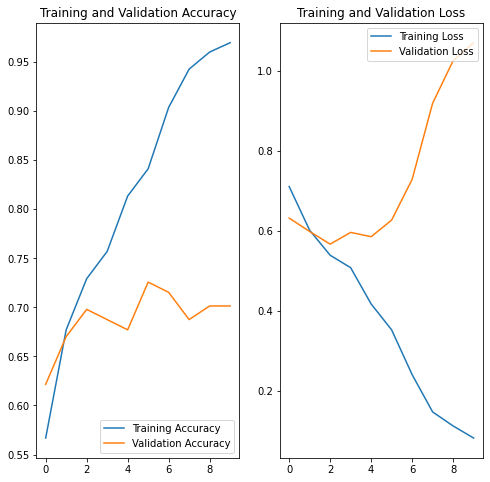

In [45]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Data Augementation

In [46]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

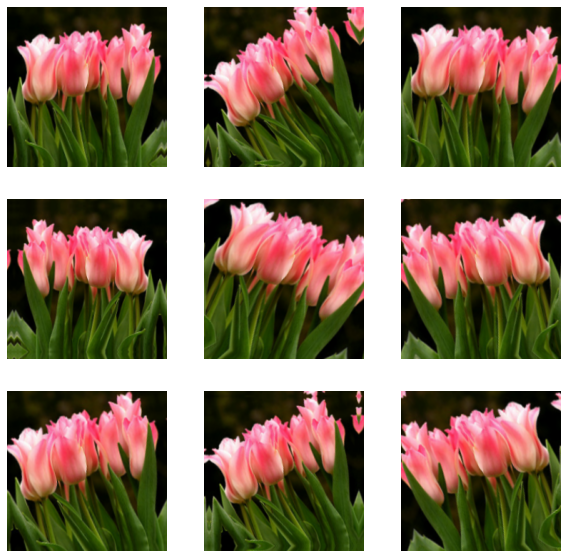

In [47]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [48]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  # layers.Dense(num_classes), # multiclass
  layers.Dense(1, activation='sigmoid') # binary
])

# tf.keras.losses.BinaryCrossentropy for binary classification
# tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) for multiclass

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [49]:
epochs = 20
with mlflow.start_run(run_name='CNN/augmentation/dropoff'):
  history = model.fit(
    train_ds,
    validation_data=val_ds,


    
    epochs=epochs
  )

Epoch 1/20
36/36 [==============================] - 22s 584ms/step - loss: 0.6840 - binary_accuracy: 0.5868 - false_negatives_1: 82.0000 - false_positives_1: 394.0000 - val_loss: 0.6401 - val_binary_accuracy: 0.5590 - val_false_negatives_1: 7.0000 - val_false_positives_1: 120.0000
Epoch 2/20
36/36 [==============================] - 20s 560ms/step - loss: 0.6003 - binary_accuracy: 0.6927 - false_negatives_1: 124.0000 - false_positives_1: 230.0000 - val_loss: 0.5729 - val_binary_accuracy: 0.7049 - val_false_negatives_1: 40.0000 - val_false_positives_1: 45.0000
Epoch 3/20
36/36 [==============================] - 20s 567ms/step - loss: 0.5712 - binary_accuracy: 0.7040 - false_negatives_1: 159.0000 - false_positives_1: 182.0000 - val_loss: 0.5610 - val_binary_accuracy: 0.7257 - val_false_negatives_1: 54.0000 - val_false_positives_1: 25.0000
Epoch 4/20
36/36 [==============================] - 20s 556ms/

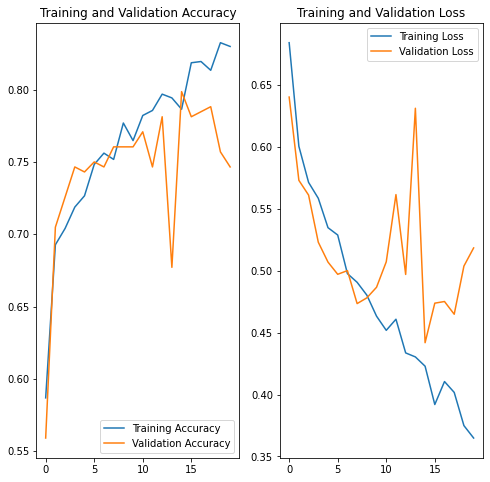

In [51]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=.01, patience=1, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[callback],
  epochs=epochs
)

2022/02/24 13:06:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '67a3e640-99b4-4e41-acd8-c090672dc13f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/20
92/92 [==============================] - 53s 569ms/step - loss: 1.2793 - accuracy: 0.4363 - val_loss: 1.0881 - val_accuracy: 0.5586
Epoch 2/20
92/92 [==============================] - 55s 601ms/step - loss: 1.0215 - accuracy: 0.5933 - val_loss: 1.0313 - val_accuracy: 0.6008
Epoch 3/20
92/92 [==============================] - 54s 593ms/step - loss: 0.9258 - accuracy: 0.6448 - val_loss: 0.9548 - val_accuracy: 0.6199
Epoch 4/20
92/92 [==============================] - 54s 582ms/step - loss: 0.8922 - accuracy: 0.6509 - val_loss: 0.8904 - val_accuracy: 0.6485
Epoch 5/20
92/92 [==============================] - 55s 599ms/step - loss: 0.8279 - accuracy: 0.6744 - val_loss: 1.0172 - val_accuracy: 0.5981
INFO:tensorflow:Assets written to: /tmp/tmpirq_e7ku/model/data/model/assets


### Register model in MLFlow 

In [52]:
# save model
model.save('models/model_1')

INFO:tensorflow:Assets written to: models/model_1/assets


In [55]:
   from azureml.core.model import Model

   model = Model.register(model_path="models/model_1",
                          model_name="cnn_with_dropout",
                          model_framework=Model.Framework.TENSORFLOW,
                          model_framework_version=tf.__version__,
                          tags={'area': "images", 'type': "classification"},
                          description="simmple CNN with dropout",
                          workspace=ws)

Registering model cnn_with_dropout


## Transfer learning aproach

### Resnet 152

In [56]:
base_model = tf.keras.applications.ResNet152(weights='imagenet', include_top=False, input_shape=(img_height,img_width,3))

# block all layers in base model
base_model.trainable = False

base_model.summary()

234708992/234698864 [==============================] - 3s 0us/step
Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                       

In [57]:
# input preprocessing layer
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [58]:
# construct whole model
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 1000)              100353000 
                                                             

In [61]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])



In [62]:
epochs=10
print(f'Batch size: {batch_size}')

with mlflow.start_run(run_name='resnet152_transfer'): # experiment tracking name
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

Batch size: 32
Epoch 1/10
36/36 [==============================] - 135s 4s/step - loss: 0.8944 - binary_accuracy: 0.8655 - false_negatives_3: 80.0000 - false_positives_3: 75.0000 - val_loss: 0.4293 - val_binary_accuracy: 0.8646 - val_false_negatives_3: 6.0000 - val_false_positives_3: 33.0000
Epoch 2/10
36/36 [==============================] - 126s 4s/step - loss: 0.1121 - binary_accuracy: 0.9627 - false_negatives_3: 19.0000 - false_positives_3: 24.0000 - val_loss: 0.3422 - val_binary_accuracy: 0.9167 - val_false_negatives_3: 11.0000 - val_false_positives_3: 13.0000
Epoch 3/10
36/36 [==============================] - 126s 4s/step - loss: 0.0457 - binary_accuracy: 0.9896 - false_negatives_3: 5.0000 - false_positives_3: 7.0000 - val_loss: 0.3658 - val_binary_accuracy: 0.9236 - val_false_negatives_3: 13.0000 - val_false_positives_3: 9.0000
Epoch 4/10
36/36 [=====

In [63]:
# save model
model_path = 'models/model_2'
model.save(model_path)

model = Model.register(model_path=model_path,
                        model_name="resnet152_transfer",
                        model_framework=Model.Framework.TENSORFLOW,
                        model_framework_version=tf.__version__,
                        tags={'area': "images", 'type': "classification"},
                        description="Transfer learning with resnet152 architecture",
                        workspace=ws)


INFO:tensorflow:Assets written to: models/model_2/assets
Registering model resnet152_transfer


### VGG19
https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19/VGG19

In [65]:
# base_model
base_model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(img_height,img_width,3))

# block all layers in base model
base_model.trainable = False

base_model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [66]:
# input preprocessing layer
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [68]:
# construct whole model
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               1284

In [69]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])



In [71]:
epochs=5
print(f'Batch size: {batch_size}')

with mlflow.start_run(run_name='VGGNET19_transfer'): # experiment tracking name
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

Batch size: 32
Epoch 1/5
36/36 [==============================] - 135s 4s/step - loss: 2.1497 - binary_accuracy: 0.8194 - false_negatives_4: 99.0000 - false_positives_4: 109.0000 - val_loss: 1.2210 - val_binary_accuracy: 0.8889 - val_false_negatives_4: 16.0000 - val_false_positives_4: 16.0000
Epoch 2/5
36/36 [==============================] - 135s 4s/step - loss: 0.3311 - binary_accuracy: 0.9592 - false_negatives_4: 22.0000 - false_positives_4: 25.0000 - val_loss: 1.3508 - val_binary_accuracy: 0.8924 - val_false_negatives_4: 22.0000 - val_false_positives_4: 9.0000
Epoch 3/5
36/36 [==============================] - 135s 4s/step - loss: 0.0275 - binary_accuracy: 0.9913 - false_negatives_4: 6.0000 - false_positives_4: 4.0000 - val_loss: 1.1074 - val_binary_accuracy: 0.8993 - val_false_negatives_4: 18.0000 - val_false_positives_4: 11.0000
Epoch 4/5
36/36 [===================

# Tensorflow HUB

In [41]:
import sys
!{sys.executable} -m pip install tensorflow_hub
import tensorflow_hub as hub

resnet_101_v2 = 'https://tfhub.dev/google/imagenet/resnet_v2_101/classification/5'
IMAGE_SHAPE = (img_height, img_width, 3)

feature_extractor_layer = hub.KerasLayer(
    resnet_101_v2,
    input_shape=IMAGE_SHAPE,
    trainable=False)

  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)


In [42]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1001)


In [43]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              44677609  
                                                                 
 dense_6 (Dense)             (None, 5)                 5010      
                                                                 
Total params: 44,682,619
Trainable params: 5,010
Non-trainable params: 44,677,609
_________________________________________________________________


In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=.001, patience=2, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[callback],
  epochs=epochs
)

2022/02/24 13:32:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3c5cec72-a215-4f87-bb44-ba8123d99db8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
INFO:tensorflow:Assets written to: /tmp/tmpui0hz64v/model/data/model/assets


Epoch 1/20
92/92 [==============================] - 242s 3s/step - loss: 131.3584 - accuracy: 0.2916 - val_loss: 59.7941 - val_accuracy: 0.3447
Epoch 2/20
92/92 [==============================] - 233s 3s/step - loss: 56.7166 - accuracy: 0.3324 - val_loss: 63.0944 - val_accuracy: 0.3079
Epoch 3/20
92/92 [==============================] - 230s 3s/step - loss: 55.9362 - accuracy: 0.3443 - val_loss: 68.5561 - val_accuracy: 0.3188
INFO:tensorflow:Assets written to: /tmp/tmpui0hz64v/model/data/model/assets


## efficientnet/b4/classification

In [59]:
eff_b4 = 'https://tfhub.dev/tensorflow/efficientnet/b4/classification/1'

In [60]:
feature_extractor_layer = hub.KerasLayer(
    eff_b4,
    input_shape=(380,380,3),
    trainable=False)

In [61]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1000)


In [78]:
num_classes = len(class_names)

model = tf.keras.Sequential([
#   layers.Rescaling(1./255, input_shape=(380, 380, 3)),
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1000)              19466816  
                                                                 
 dense_10 (Dense)            (None, 5)                 5005      
                                                                 
Total params: 19,471,821
Trainable params: 5,005
Non-trainable params: 19,466,816
_________________________________________________________________


In [79]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [80]:
with mlflow.start_run(run_name='efficientnet/b4/classification'):
    history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
    )

Epoch 1/20
92/92 [==============================] - 1290s 14s/step - loss: 1.6086 - accuracy: 0.2129 - val_loss: 1.6080 - val_accuracy: 0.2262
Epoch 2/20
47/92 [==============>...............] - ETA: 9:24 - loss: 1.6016 - accuracy: 0.2547